In [1]:
import os, math
from collections import defaultdict, namedtuple, deque
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_1024'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = numpy


In [78]:
%run sequencing_sp.ipynb

In [4]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'sim'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [5]:
hdc = Hdc(10_000, xp)

In [6]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.81 μs


((100, 5), (20, 5))


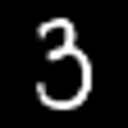
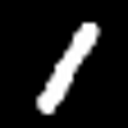
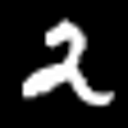
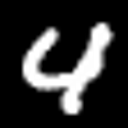
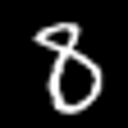
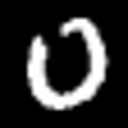
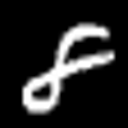
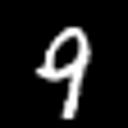
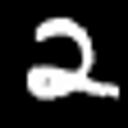
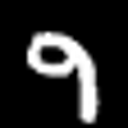
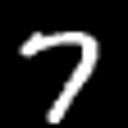
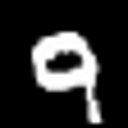
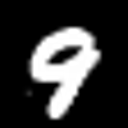
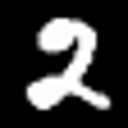
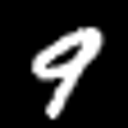
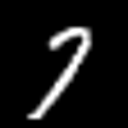

In [7]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [8]:
class Engram(object):
    def __init__(self):
        self.roles = pd.DataFrame(columns=['lv']) # lv - latent vector
        self.relations = pd.DataFrame(columns=['rel_mnem', 'lp', 'rp', 'rel_val'])

        self.image_id = -1
        self.value = -1

In [9]:
class RelationValue(StrEnum):
    BLANK = ''
    NA = auto()
    
    WHERE_IN_FRONT = auto()
    WHERE_TO_THE_LEFT = auto()
    WHERE_TO_THE_RIGHT = auto()
    WHERE_BEHIND = auto() 

    LEN_EQ = auto()
    LEN_SHORTER = auto()
    LEN_LONGER = auto()
    LEN_MUCH_SHORTER = auto()
    LEN_MUCH_LONGER = auto()

In [10]:
COS_SIM_45 = np.sqrt(2) / 2
COS_SIM_30 = np.sqrt(3) / 2

class RelationCalc(StrEnum):
    WHERE = auto()
    LEN = auto()

    @staticmethod
    def calc_where_relation(lp, rp):
        assert len(lp) > 0, len(lp)
        assert len(rp) > 0, len(rp)
        lp = lp[0]
        rp = rp[0]
        between_vec = rp.x - lp.x, rp.y - lp.y
        lp_normal_vec = lp.normal_vec.real, lp.normal_vec.imag
        dp = between_vec[0] * lp_normal_vec[0] + between_vec[1] * lp_normal_vec[1]
        cos_sim = dp / (np.linalg.norm(between_vec) * 1) # ... * 1) - since normal_vec is already normalized

        if cos_sim > COS_SIM_45:
            return RelationValue.WHERE_IN_FRONT
        elif cos_sim < -COS_SIM_45:
            return RelationValue.WHERE_BEHIND
            
        normal_diff = get_angle_diff(lp.normal, np.angle(complex(between_vec[0], between_vec[1]), deg=True))

        if normal_diff > 45:
            return RelationValue.WHERE_TO_THE_LEFT
        else:
            return RelationValue.WHERE_TO_THE_RIGHT
    
    def calc_len_relation(lp, rp):
        assert len(lp) > 1, len(lp)
        assert len(rp) > 1, len(rp)
        l_segment_len = np.linalg.norm([lp[1].x - lp[0].x, lp[1].y - lp[0].y])
        r_segment_len = np.linalg.norm([rp[1].x - rp[0].x, rp[1].y - rp[0].y])
    
        if np.isclose(l_segment_len, 0) and np.isclose(r_segment_len, 0):
            return RelationValue.NA
    
        if l_segment_len < r_segment_len:
            ratio = l_segment_len / r_segment_len
    
            if ratio >= 0.8:
                return RelationValue.LEN_EQ
            elif ratio >= 0.2:
                return RelationValue.LEN_SHORTER
            else:
                return RelationValue.LEN_MUCH_SHORTER
        else:
            ratio = r_segment_len / l_segment_len
    
            if ratio >= 0.8:
                return RelationValue.LEN_EQ
            elif ratio >= 0.2:
                return RelationValue.LEN_LONGER
            else:
                return RelationValue.LEN_MUCH_LONGER

    @staticmethod
    def calc(mnem, lp, rp):
        match mnem:
            case RelationCalc.WHERE: 
                return RelationCalc.calc_where_relation(lp, rp)
            case RelationCalc.LEN: 
                return RelationCalc.calc_len_relation(lp, rp)
            case _:
                assert False

In [487]:
l = [1,2,3,4,5]
l[1:1+3]

[2, 3, 4]

In [488]:
def calc_desired_rels_count(roles_count, si_count):
    l = 0.01
    b = 1.1 + l * math.exp(-l * si_count)
    y = math.log(roles_count, b)
    return int(y)

def calc_latent_vectors_old(sequences, sensor_instance_ind_dict, max_neighbours_count=5, alpha=0.5):
    def si_ind_to_expanded_normal_vec(si_ind):
        si = sensor_instance_ind_dict[si_ind]
        return np.array([si.normal_vec.real, si.normal_vec.imag])
    
    sensor_instance_ind_to_latent_vector = {}
    # e.g. for alpha=0.5 and max_neighbours_count=5 this produces [0.25, 0.125, 0.0625, 0.03125, 0.015625]
    neigbh_mults = list(itertools.accumulate([alpha] * (max_neighbours_count - 1), lambda x, y: x * y, initial=alpha**2))
    neigbh_mults = np.array(list(zip(neigbh_mults, neigbh_mults))).ravel()
    
    for seq in sequences:
        neighbours_count_for_seq = min(max_neighbours_count, len(seq) - 1)
        
        pre_si_inds = list(reversed((seq[-neighbours_count_for_seq:] + seq[max(0, -neighbours_count_for_seq):0])[-neighbours_count_for_seq:]))
        pre_normal_vecs = deque(map(si_ind_to_expanded_normal_vec, pre_si_inds))
        # pre_normal_vecs = deque(pre_si_inds)
        # print(pre_normal_vecs)
        
        post_si_inds = (seq[1:1+neighbours_count_for_seq] + seq[:neighbours_count_for_seq])[:neighbours_count_for_seq]
        post_normal_vecs = deque(map(si_ind_to_expanded_normal_vec, post_si_inds))
        # post_normal_vecs = deque(post_si_inds)
        i_for_last_post = 0 + neighbours_count_for_seq
        # print(post_normal_vecs)
        assert len(pre_normal_vecs) == len(post_normal_vecs)
        pads = [np.array([0, 0])] * (max_neighbours_count - neighbours_count_for_seq)
        
        for i, si_ind in enumerate(seq):
            # print(f'{i} {pre_normal_vecs}')
            # print(f'{i} {post_normal_vecs}')
            latent_vector = []
            # latent_vector.append(si_ind_to_expanded_normal_vec(si_ind) * alpha)
            # latent_vector.append(np.array(list(pre_normal_vecs) + pads).ravel() * neigbh_mults)
            # latent_vector.append(np.array(list(post_normal_vecs) + pads).ravel() * neigbh_mults)

            latent_vector.append(si_ind_to_expanded_normal_vec(si_ind))
            latent_vector.append(np.array(list(pre_normal_vecs) + pads).ravel())
            latent_vector.append(np.array(list(post_normal_vecs) + pads).ravel())
            
            latent_vector = np.hstack(latent_vector)
            assert latent_vector.shape == ((1 + max_neighbours_count * 2) * 2,), latent_vector.shape
            sensor_instance_ind_to_latent_vector[si_ind] = latent_vector
    
            pre_normal_vecs.pop()
            pre_normal_vecs.appendleft(si_ind_to_expanded_normal_vec(si_ind))
            # pre_normal_vecs.appendleft(si_ind)
            assert len(pre_normal_vecs) == neighbours_count_for_seq
    
            post_normal_vecs.popleft()
            i_for_last_post += 1
            i_for_last_post = 0 if i_for_last_post >= len(seq) else i_for_last_post
            post_normal_vecs.append(si_ind_to_expanded_normal_vec(seq[i_for_last_post]))
            # post_normal_vecs.append(seq[i_for_last_post])
            assert len(post_normal_vecs) == neighbours_count_for_seq
        
    return sensor_instance_ind_to_latent_vector

def calc_latent_vectors(sequences, sensor_instance_ind_dict, max_neighbours_count=3):
    def _calc_normal_vector(si_ind):
        si = sensor_instance_ind_dict[si_ind]
        return np.array([si.normal_vec.real, si.normal_vec.imag])

    def _calc_connection_vector(si_ind_from, si_ind_to):
        si_from = sensor_instance_ind_dict[si_ind_from]
        si_to = sensor_instance_ind_dict[si_ind_to]
        return np.array([si_to.x - si_from.x, si_to.y - si_from.y])
    
    sensor_instance_ind_to_latent_vector = {}
    
    for seq in sequences:
        normal_vectors = list(map(lambda si_ind: _calc_normal_vector(si_ind), seq))
        
        seq_pairs = zip(seq[-1:] + seq[:-1], seq)
        connection_vectors = list(map(lambda si_inds: _calc_connection_vector(si_inds[0], si_inds[1]), seq_pairs))
        connection_vectors = np.array(connection_vectors)
        connection_vectors = (connection_vectors.T / np.linalg.norm(connection_vectors, axis=1)).T
        
        neighbours_count_for_seq = min(max_neighbours_count, len(seq) - 1)
        
        # look-behind
        pre_vecs = deque()

        for i, si_ind in enumerate(seq[-neighbours_count_for_seq:]):
            normal_vector = normal_vectors[-neighbours_count_for_seq+i]
            connection_vector = connection_vectors[-neighbours_count_for_seq+i]
            pre_vecs.appendleft(np.hstack([normal_vector, connection_vector]))

        # look-ahead
        post_vecs = deque()

        for i, si_ind in enumerate(seq[1:1+neighbours_count_for_seq]):
            normal_vector = normal_vectors[i]
            connection_vector = connection_vectors[i]
            post_vecs.append(np.hstack([normal_vector, connection_vector]))

        i_for_last_post = 0 + neighbours_count_for_seq
        assert len(pre_vecs) == len(post_vecs)
        pads = [np.array([0, 0, 0, 0])] * (max_neighbours_count - neighbours_count_for_seq)
        
        for i, si_ind in enumerate(seq):
            # print(f'{i} {si_ind} {connection_vectors[i]}')
            # print(f'{i} {si_ind} {pre_vecs}')
            latent_vector = []

            latent_vector_head = np.hstack([normal_vectors[i], connection_vectors[i]])
            latent_vector.append(latent_vector_head)
            latent_vector.append(np.array(list(pre_vecs) + pads).ravel())
            latent_vector.append(np.array(list(post_vecs) + pads).ravel())
            
            latent_vector = np.hstack(latent_vector)
            # print(f'{i} {si_ind} {latent_vector}')
            assert latent_vector.shape == ((1 + max_neighbours_count * 2) * 4,), latent_vector.shape
            sensor_instance_ind_to_latent_vector[si_ind] = latent_vector
    
            pre_vecs.pop()
            pre_vecs.appendleft(latent_vector_head)
            assert len(pre_vecs) == neighbours_count_for_seq

            post_vecs.popleft()
            i_for_last_post += 1
            i_for_last_post = 0 if i_for_last_post >= len(seq) else i_for_last_post
            post_vecs.append(np.hstack([normal_vectors[i_for_last_post], connection_vectors[i_for_last_post]]))
            assert len(post_vecs) == neighbours_count_for_seq
        
    return sensor_instance_ind_to_latent_vector
    
def get_engram_blank(sequences, sensor_instance_ind_dict, sensor_instance_ind_to_latent_vector):
    si_ind_flat_list = list(itertools.chain.from_iterable(sequences))
    si_count = len(si_ind_flat_list)
    where_roles_count = math.comb(si_count, 2) # si_count * (si_count - 1) // 2
    len_roles_count = math.comb(where_roles_count, 2) # where_roles_count * (where_roles_count - 1) // 2 
    
    where_rels_count = calc_desired_rels_count(where_roles_count, si_count)
    len_rels_count = calc_desired_rels_count(len_roles_count, si_count)
    
    where_rel_si_ind_pairs = []
    
    if (where_rels_count / where_roles_count) > 0.1:
        where_rel_si_ind_pairs = list(itertools.combinations(si_ind_flat_list, 2))
        RNG.shuffle(where_rel_si_ind_pairs)
        where_rel_si_ind_pairs = where_rel_si_ind_pairs[:where_rels_count]
    else:
        unique_pairs = set()
    
        while len(where_rel_si_ind_pairs) < where_rels_count:
            pair = tuple(RNG.choice(si_ind_flat_list, 2, replace=False))
    
            if not pair in unique_pairs:
                unique_pairs.add(pair)
                where_rel_si_ind_pairs.append(pair)
    
    len_rel_si_ind_quartets = []
    
    if True:
        unique_quartets = set()
        
        while len(len_rel_si_ind_quartets) < len_rels_count:
            # Sampling in two turns to allow adjacent segments (e.g. AB, BC)
            pair1 = tuple(sorted(RNG.choice(si_ind_flat_list, 2, replace=False)))
            pair2 = tuple(sorted(RNG.choice(si_ind_flat_list, 2, replace=False)))
    
            if pair1 == pair2:
                continue
    
            quartet = (*pair1, *pair2)
        
            if not quartet in unique_quartets:
                unique_quartets.add(quartet)
                len_rel_si_ind_quartets.append(quartet)

    engram_roles = set()
    engram_relations = defaultdict(list)
    
    for (lp_si_ind, rp_si_ind) in where_rel_si_ind_pairs: 
        engram_relations['rel_mnem'].append(RelationCalc.WHERE)
        engram_relations['rel_val'].append(RelationValue.BLANK)
        engram_relations['lp'].append([lp_si_ind])
        engram_relations['rp'].append([rp_si_ind])
        
        engram_roles.add(sensor_instance_ind_dict[lp_si_ind])
        engram_roles.add(sensor_instance_ind_dict[rp_si_ind])
    
    for (lp_si_ind1, lp_si_ind2, rp_si_ind1, rp_si_ind2) in len_rel_si_ind_quartets:
        engram_relations['rel_mnem'].append(RelationCalc.LEN)
        engram_relations['rel_val'].append(RelationValue.BLANK)
        engram_relations['lp'].append([lp_si_ind1, lp_si_ind2])
        engram_relations['rp'].append([rp_si_ind1, rp_si_ind2])
        
        engram_roles.add(sensor_instance_ind_dict[lp_si_ind1])
        engram_roles.add(sensor_instance_ind_dict[lp_si_ind2])
        engram_roles.add(sensor_instance_ind_dict[rp_si_ind1])
        engram_roles.add(sensor_instance_ind_dict[rp_si_ind2])
    
    engram = Engram()
    build_role_vec = lambda si: (si.Index, sensor_instance_ind_to_latent_vector[si.Index])
    new_engram_roles = pd.DataFrame(pd.Series(dict(map(build_role_vec, engram_roles)), name='lv'))
    engram.roles = pd.concat([engram.roles, new_engram_roles])
    engram.relations = pd.concat([engram.relations, pd.DataFrame(engram_relations)])
    return engram

def calc_engram_blank(engram_blank, sensor_instance_ind_dict):
    rel_val_column = {}
    
    for rel in engram_blank.relations.itertuples():
        lp_si_list = list(map(sensor_instance_ind_dict.get, rel.lp))
        rp_si_list = list(map(sensor_instance_ind_dict.get, rel.rp))
        rel_val_column[rel.Index] = RelationCalc.calc(rel.rel_mnem, lp_si_list, rp_si_list)

    engram_blank.relations.rel_val = pd.Series(rel_val_column)

In [77]:
# ENGRAMS_bak = ENGRAMS.copy()

In [330]:
ENGRAMS = []

In [531]:
%%time

train_runs = 1
count = min(100, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [28977]

    for image_id in image_ids:
        df_image = df_train_images.loc[image_id]
        sensor_instance_ind_dict = pickle.loads(df_image['si'])
        sequences_full = pickle.loads(df_image['seq'])
        sequences_full = cw_orient_sequences(sequences_full, sensor_instance_ind_dict) # TODO: remove (cw_orient_sequences is already in prep_dataset)
        sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
        sensor_instance_ind_to_latent_vector = calc_latent_vectors(sequences, sensor_instance_ind_dict)
        engram = get_engram_blank(sequences, sensor_instance_ind_dict, sensor_instance_ind_to_latent_vector)
        calc_engram_blank(engram, sensor_instance_ind_dict)
        engram.image_id = image_id
        engram.value = int(df_image['value'])
        ENGRAMS.append(engram)

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 630 ms, sys: 0 ns, total: 630 ms
Wall time: 627 ms


In [491]:
np.round(sensor_instance_ind_to_latent_vector[485].reshape(-1, 4), decimals=2)

array([[ 0.34, -0.94,  1.  ,  0.02],
       [-0.  , -1.  ,  0.99,  0.16],
       [ 0.98,  0.17, -0.45,  0.89],
       [ 0.77,  0.64, -0.88,  0.48],
       [ 1.  ,  0.  ,  0.65,  0.76],
       [ 0.17,  0.98, -0.94,  0.34],
       [ 0.34,  0.94, -1.  ,  0.05]])

In [329]:
# for engram in ENGRAMS:
#     if engram.image_id != 28977:
#         continue
        
#     df_image = df_train_images.loc[engram.image_id]
#     sensor_instance_ind_dict = pickle.loads(df_image['si'])
#     sequences_full = pickle.loads(df_image['seq'])
#     sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
#     sequences = cw_orient_sequences(sequences, sensor_instance_ind_dict)
#     sensor_instance_ind_to_latent_vector = calc_latent_vectors(sequences, sensor_instance_ind_dict)

#     engram_roles = filter(lambda si_ind: si_ind in sensor_instance_ind_to_latent_vector, engram.roles.index)
#     build_role_vec = lambda si_ind: (si_ind, sensor_instance_ind_to_latent_vector[si_ind])
#     engram.roles = pd.DataFrame(pd.Series(dict(map(build_role_vec, engram_roles)), name='lv'))    

In [503]:
def get_image_with_sequences(image_id, df_images, highlight_si_inds=set(), normal_color='red', highlight_color='darkred', lowlight_color='gray'):
    df_image = df_images.loc[image_id]
    sensor_instance_ind_dict = pickle.loads(df_image['si'])
    sequences_full = pickle.loads(df_image['seq'])
    sequences_full = cw_orient_sequences(sequences_full, sensor_instance_ind_dict)
    sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)

    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize((600, 600))
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    sequences_si = [list(map(lambda si_ind: sensor_instance_ind_dict[si_ind], seq)) for seq in sequences]
    
    for seq in sequences_si:
        for si_from, si_to in zip(seq, seq[1:] + seq[:1]):
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill=normal_color)
            
            color = normal_color

            if highlight_si_inds:
                color = highlight_color if si_from.Index in highlight_si_inds else lowlight_color

            # print(color)
            
            nl = 8 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline=color)
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_from.Index), anchor='mm', fill=color)

            color = normal_color
            
            if highlight_si_inds:
                color = highlight_color if si_to.Index in highlight_si_inds else lowlight_color
    
            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline=color)
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_to.Index), anchor='mm', fill=color)

    return image   

In [508]:
image_index = RNG.choice(df_train_images.index)
# image_index = 10710
# image_index = 17261
# image_index = 2328
# image_index = 18640
image_index = 20291
df_image = df_train_images.loc[image_index]
sensor_instance_ind_dict = pickle.loads(df_image['si'])
sequences_full = pickle.loads(df_image['seq'])
sequences_full = cw_orient_sequences(sequences_full, sensor_instance_ind_dict)
sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)

In [509]:
sensor_instance_ind_to_latent_vector = calc_latent_vectors(sequences, sensor_instance_ind_dict)
engram_blank = get_engram_blank(sequences, sensor_instance_ind_dict, sensor_instance_ind_to_latent_vector)
# calc_engram_blank(engram_blank, sensor_instance_ind_dict)

In [550]:
engram_i = RNG.choice(len(ENGRAMS))
engram = ENGRAMS[engram_i]

In [551]:
engram_blank_roles_lv_mat = np.array(engram_blank.roles['lv'].to_list())
engram_blank_roles_lv_mat = (engram_blank_roles_lv_mat.T / np.linalg.norm(engram_blank_roles_lv_mat, axis=1)).T

engram_roles_lv_mat = np.array(engram.roles['lv'].to_list())
engram_roles_lv_mat = (engram_roles_lv_mat.T / np.linalg.norm(engram_roles_lv_mat, axis=1)).T

cos_sims = engram_roles_lv_mat @ engram_blank_roles_lv_mat.T
cos_sims_indices = np.argsort(-cos_sims, axis=1)

candidates = defaultdict(list)

for i, candidate_indices_for_i in enumerate(cos_sims_indices):
    role = int(engram.roles.index[i])

    for j, candidate_index_for_i in enumerate(candidate_indices_for_i):
        cos_sim = cos_sims[i, candidate_index_for_i]

        if cos_sim < COS_SIM_45:
            break

        candidate = int(engram_blank.roles.index[candidate_index_for_i])
        candidates[role].append(candidate)

In [539]:
candidates

defaultdict(list,
            {583: [363, 264],
             495: [214, 196],
             209: [410, 46, 299, 45, 498],
             368: [205, 246],
             75: [299, 254, 46, 37, 410],
             665: [45, 53, 498, 548],
             231: [588, 582, 593],
             193: [582, 138, 548, 113, 588, 176, 83],
             516: [254, 9, 196, 299, 37],
             191: [163, 341],
             521: [413, 504],
             560: [299, 37, 46, 254],
             643: [588],
             44: [254, 196, 9, 37, 299],
             113: [138, 113, 176, 83, 53],
             506: [298, 349],
             8: [6, 91, 196, 214],
             156: [138, 113, 83, 176, 548, 53, 582, 205],
             588: [264, 214],
             597: [504, 413, 560],
             109: [143, 91],
             529: [446, 363, 404],
             251: [560, 504],
             431: [143, 91, 163],
             226: [413, 504],
             353: [410, 205, 498, 45, 53, 176],
             579: [83, 53],
         

In [467]:
np.round(engram.roles.loc[485].lv.reshape(-1, 4), decimals=4)

array([[ 0.342 , -0.9397,  0.9997,  0.0227],
       [-0.    , -1.    ,  0.9864,  0.1644],
       [ 0.9848,  0.1736, -0.4472,  0.8944],
       [ 0.766 ,  0.6428, -0.8752,  0.4837],
       [ 0.6428,  0.766 , -0.7071,  0.7071],
       [ 0.866 ,  0.5   , -0.1104,  0.9939]])

In [468]:
np.round(engram_blank.roles.loc[264].lv.reshape(-1, 4), decimals=4)

array([[-0.5   , -0.866 ,  0.6332, -0.774 ],
       [-0.6428, -0.766 ,  0.7071, -0.7071],
       [ 0.766 , -0.6428,  0.3714,  0.9285],
       [ 1.    ,  0.    , -0.3162,  0.9487],
       [ 0.9397,  0.342 , -0.7071,  0.7071],
       [ 0.866 ,  0.5   , -0.4472,  0.8944]])

In [466]:
(engram.roles.loc[485].lv @ engram_blank.roles.loc[264].lv) / (np.linalg.norm(engram.roles.loc[485].lv) * np.linalg.norm(engram_blank.roles.loc[264].lv))

np.float64(0.768230348595417)


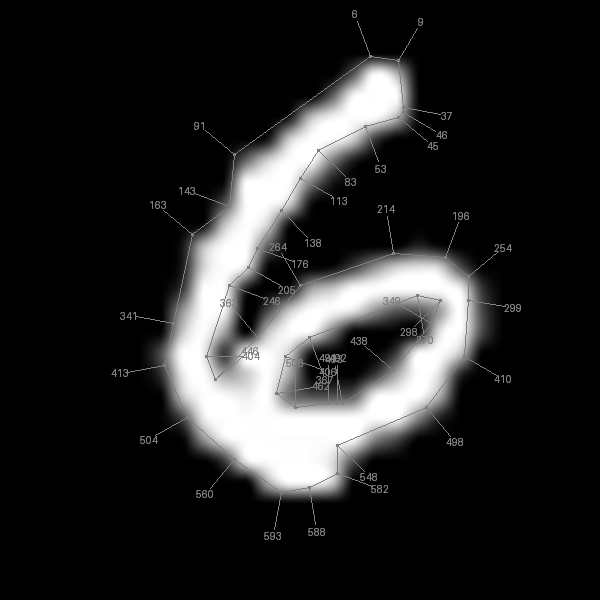
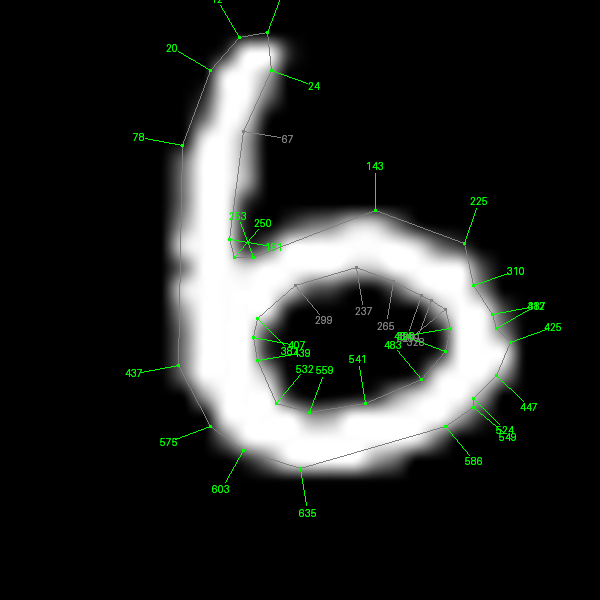

In [552]:
image1 = get_image_with_sequences(image_index, df_train_images, 
                                  # highlight_si_inds=set(itertools.chain.from_iterable(candidates.values())),
                                  highlight_si_inds=candidates[38],
                                  # highlight_si_inds=[493],
                                  normal_color='gray', highlight_color='red', lowlight_color='gray')
image2 = get_image_with_sequences(engram.image_id, df_train_images, 
                                  highlight_si_inds=set(candidates.keys()), 
                                  # highlight_si_inds=set([185]), 
                                  normal_color='gray', highlight_color='lime', lowlight_color='gray')
display_images([image1, image2], captions=[f'{image_index}, {df_image['value']}', f'{engram.image_id}'])

In [ ]:
# array([[ 0.34, -0.94,  1.  ,  0.02],
#        [-0.  , -1.  ,  0.99,  0.16],
#        [ 0.98,  0.17, -0.45,  0.89],
#        [ 0.77,  0.64, -0.88,  0.48],
#        [ 1.  ,  0.  ,  0.65,  0.76],
#        [ 0.17,  0.98, -0.94,  0.34],
#        [ 0.34,  0.94, -1.  ,  0.05]])

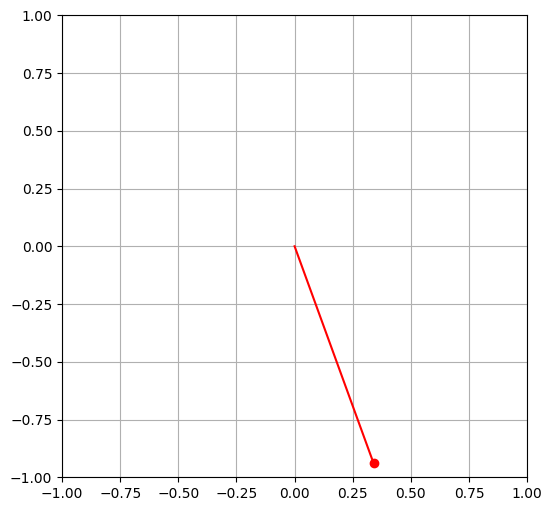

In [501]:
vec1 = [0.34,  0.94]

plt.figure(figsize=(6, 6))
plt.plot([0, vec1[0]], [0, -vec1[1]], 'r')
plt.scatter(vec1[0], -vec1[1], c='r')
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.grid()
plt.show()

In [ ]:
assert False

In [ ]:
%%time

train_runs = 2 * 50
attempts_to_get_no_mistakes = 10
count = min(1000, len(df_train_images))
consolidation_threshold = 1000

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    
    for column_id, column in COLUMN_HOSTS.items():
        column.train_start(TRAIN_RUN_ID, image_ids, consolidation_threshold, attempts_to_get_no_mistakes)

    for column_id, column in COLUMN_HOSTS.items():
        column.train_finish()

In [ ]:
# TEST RUN
TEST_RUN_ID += 1
count = min(2000, len(test_run_source[0]))
# test_run_source = (df_test_images, test_db_con, 'test')
test_run_source = (df_train_images, train_db_con, 'train')
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
column_id_whitelist = COLUMN_HOSTS.keys()
# column_id_whitelist = [3]
assert np.all(np.array(list(map(lambda i: i in COLUMN_HOSTS, column_id_whitelist))) == 1)

for image_id in tqdm(test_image_ids):
    image_value = test_run_source[0].loc[image_id]['value']
    column_votes_vectors = []
    column_votes_vector = np.zeros(10)
    column_images_seen = {}
    
    for column_id, column_host in COLUMN_HOSTS.items():
        if not column_id in column_id_whitelist:
            continue

        column_host.infer_start(image_id, test_run_source[2])

    for column_id, column_host in COLUMN_HOSTS.items():
        if not column_id in column_id_whitelist:
            continue

        column_votes_vector_, column_images_seen_ = column_host.infer_finish()
        column_votes_vector += column_votes_vector_
        column_votes_vectors.append(column_votes_vector_)
        column_images_seen.update(column_images_seen_)

    infer_value = ''
    
    if np.any(column_votes_vector) > 0:
        # digit_probabilities = softmax(column_votes_vector)
        # infer_value = str(RNG.choice(10, p=digit_probabilities))
        infer_value = str(np.argmax(column_votes_vector)) # softmax([0,0,0,0,0,0,0,0,0,4]) will produce probs [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.9]
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(sorted(column_id_whitelist))
    test_result_rows['train_images_count'].append(max(list(column_images_seen.values())))
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value) 
    test_result_rows['sim'].append(np.array(column_votes_vectors))
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

In [ ]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [ ]:
df = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == 1]
df_incorrect = df.loc[df.true_value != df.infer_value]
df_incorrect